### DEADLINE  11.02.2022

Само Дз описано в конце ноутбука

# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim

torch.__version__

'1.6.0+cpu'

In [37]:
import numpy as np
import random
from tqdm import tqdm # способ создания индикаторов прогресса в python,

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [38]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

In [39]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [40]:
for i in trainset:
    break

In [41]:
type(i)

tuple

In [42]:
i[1]

9

In [43]:
#trainset[0][0]*255 # отнормированный тензор

In [44]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

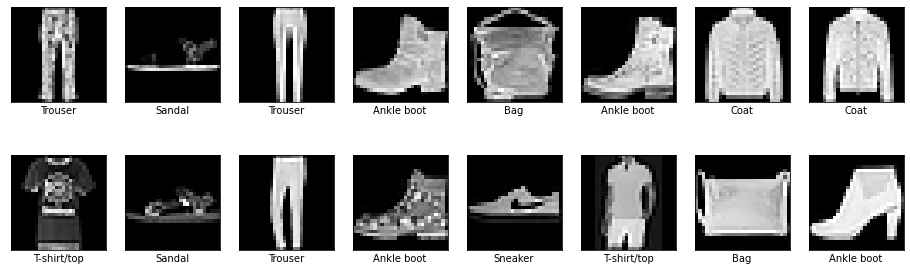

In [45]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция (свертка)
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг (свертка по максимуму окна)
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут. (отключение нейронов, пересмотреть лекцию)


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [46]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [47]:
DEVICE

'cpu'

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [48]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [49]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Домашнее задание:

  добавить в pipeline расчет точности в дополнение к loss (функция training_loop)
улучшить качество обеих моделей (FC и CNN). 

  В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
  Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. 
   Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

In [50]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [51]:
## свой оптимайзер для каждого экземпляра класса
## свой оптимайзер для каждого экземпляра класса
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.model_layer_1 = nn.Linear(784, 64)# количество входящих и исходящих фич
        nn.init.xavier_normal_(self.model_layer_1.weight)# инициализация весов по Ксавье
        self.model_layer_2 = nn.BatchNorm1d(64)# нормализация
        self.model_layer_4 = nn.BatchNorm1d(16)
        self.model_layer_3 = nn.Linear(16, 10)
        self.classifier = nn.Sequential(self.model_layer_1,  # 28 x 28 = 784
                                        nn.ReLU(),
                                        self.model_layer_2,
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        self.model_layer_4,
                                        nn.ReLU(),
                                        self.model_layer_3,
                                    )
        
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs


from copy import deepcopy
class Main_train_loop():
    def __init__(self,batch_size,trainloader,testloader,Device,model): 
        self.batch_size = batch_size
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = Device
        self.model = model
        self.loss_arr = []
        self.loss_arr_test = []
        self.metric_train = []
        self.metric_test = []
        # self.get_part_train_loop()
    def get_part_train_loop(self): #,type_of_optimizer): - добавить выборк
      self.loss_fn = nn.CrossEntropyLoss()#Этот критерий вычисляет потерю перекрестной энтропии между входом и целью
      self.opt = optim.SGD(self.model.parameters(), lr=0.01)#Реализует стохастический градиентный спуск (опционально с импульсом)

    def accurancy(self,y_predicts,data_y):
      # y_predicts = torch.tensor(y_predicts)
      self.y_predicts = y_predicts
      self.data_y = data_y
      acc = (y_predicts == data_y).sum().item() / y_predicts.size(0)
      return acc

    def train_nn(self,trainloader, model, opt, loss_fn, device):
      running_loss = []
      model.train()
      acc_list = []
      
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data # Взятие данных
          inputs = inputs.to(device)

          opt.zero_grad()
          outputs,probs = model(inputs)
          y_pred = outputs.cpu().argmax(dim=1)
          loss = loss_fn(outputs.cpu(), labels)
          loss.backward()
          opt.step()
          
          running_loss.append(loss.item())
          acc_list.append(self.accurancy(y_pred,
                                           labels))

      return model, running_loss,acc_list


    def eval_nn(self,testloader, model, loss_fn, device):
        running_loss_test = []
        acc_list = []

        model.eval()
        predicts = np.array([])
        
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs,proba = model(inputs)
            y_pred = outputs.cpu().argmax(dim=1)
            predicts = np.append(predicts,y_pred)
            loss = loss_fn(outputs.cpu(), labels)

            running_loss_test.append(loss.item())
            acc_list.append(self.accurancy(y_pred,
                                           labels))
        return running_loss_test, predicts.astype(int),acc_list

    def training_loop(self, max_epochs=20):
      
      for epoch in range(max_epochs):        
          self.model, running_loss,acc_train = self.train_nn(self.trainloader, 
                                                             self.model,
                                         self.opt, self.loss_fn, self.device)
          running_loss_test, _,acc_eval = self.eval_nn(self.testloader,
                                         self.model,
                                         self.loss_fn, self.device)

          self.loss_arr.append(np.mean(running_loss))
          self.loss_arr_test.append(np.mean(running_loss_test))


          self.metric_train.append(np.mean(acc_train))
          self.metric_test.append(np.mean(acc_eval))
          if np.mean(acc_eval)>=np.max(self.metric_test):
            self.best_model = deepcopy(self.model)
            self.best_epoch = epoch

          if epoch % 4 == 0:
              print(f"""EPOCH {epoch} : train_loss: {self.loss_arr[-1]:.5f} 
              test_loss: {self.loss_arr_test[-1]:.5f}""")

      
        




In [52]:
model = FC()
model.to(DEVICE)
main_loop = Main_train_loop(batch_size,trainloader,testloader,DEVICE,model)
main_loop.get_part_train_loop()

In [53]:
main_loop.training_loop(max_epochs=2)

EPOCH 0 : train_loss: 1.83636 
              test_loss: 1.55023


In [54]:
main_loop.best_epoch

1

In [55]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                  out_channels=6,
                                                  kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=6,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs
#         return logits

1) Смотрим на оптимайзер - перевод более идеальное состояние (Адам,1e-4)  
2) Добавляем в класс сохранение модели на лучшей эпохи (сохраняемся всегда по валидации)  
3) Поменял функции активации на релу  
4) Добавить инициализацию (хе и ксавье. 5ая неделя)  
5) Понять что наступает первое - переобучение или недообучение (недообучение - эпохи идут качество на трейне такое же.   Переобучение - качетсво на тесте не меняется, качество на трейне растет. Большое различие между трейном и тестом.) Если недообучение - усложнить модель - слои или количество нейронов на слое. Если переобучаемся - регуляризации (третья неделя) либо упрощаем.  
6)

In [56]:
model_2 = CNN()
model_2.to(DEVICE)
main_loop_cnn = Main_train_loop(batch_size,trainloader,testloader,DEVICE,model_2)
main_loop_cnn.get_part_train_loop()
main_loop_cnn.training_loop(max_epochs=40)

EPOCH 0 : train_loss: 2.29624 
              test_loss: 2.28562
EPOCH 4 : train_loss: 1.73910 
              test_loss: 1.55245
EPOCH 8 : train_loss: 1.06462 
              test_loss: 1.05179
EPOCH 12 : train_loss: 0.91576 
              test_loss: 0.92008
EPOCH 16 : train_loss: 0.80082 
              test_loss: 0.80964
EPOCH 20 : train_loss: 0.73874 
              test_loss: 0.75468
EPOCH 24 : train_loss: 0.70240 
              test_loss: 0.72334
EPOCH 28 : train_loss: 0.67918 
              test_loss: 0.70086
EPOCH 32 : train_loss: 0.65996 
              test_loss: 0.68222
EPOCH 36 : train_loss: 0.64391 
              test_loss: 0.66884


In [57]:
dir(main_loop_cnn)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'accurancy',
 'batch_size',
 'best_epoch',
 'best_model',
 'data_y',
 'device',
 'eval_nn',
 'get_part_train_loop',
 'loss_arr',
 'loss_arr_test',
 'loss_fn',
 'metric_test',
 'metric_train',
 'model',
 'opt',
 'testloader',
 'train_nn',
 'training_loop',
 'trainloader',
 'y_predicts']

In [58]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [59]:
iter(trainloader).next()[0].shape

torch.Size([512, 1, 28, 28])

In [60]:
torch.cuda.is_available()

False

In [61]:
# !watch -n 5 nvidia-smi

In [62]:
device = 'cpu'  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cpu


In [64]:
#model_fc()

In [65]:
for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        break

In [66]:
logit,proba = model_fc(inputs)

In [67]:
proba

tensor([[0.0830, 0.0714, 0.1177,  ..., 0.0538, 0.1108, 0.1079],
        [0.0652, 0.0998, 0.0932,  ..., 0.0484, 0.0909, 0.1304],
        [0.1134, 0.1342, 0.1192,  ..., 0.0964, 0.0767, 0.0703],
        ...,
        [0.0958, 0.0931, 0.1473,  ..., 0.0530, 0.1203, 0.0957],
        [0.0813, 0.0842, 0.1244,  ..., 0.0522, 0.0940, 0.1076],
        [0.0723, 0.1426, 0.0853,  ..., 0.0795, 0.0974, 0.1348]],
       grad_fn=<SoftmaxBackward>)

In [68]:
logit

tensor([[-0.3305, -0.4812,  0.0191,  ..., -0.7640, -0.0407, -0.0677],
        [-0.4900, -0.0633, -0.1320,  ..., -0.7866, -0.1574,  0.2035],
        [ 0.0389,  0.2072,  0.0886,  ..., -0.1237, -0.3518, -0.4393],
        ...,
        [-0.2379, -0.2670,  0.1917,  ..., -0.8308, -0.0105, -0.2397],
        [-0.3272, -0.2923,  0.0983,  ..., -0.7706, -0.1824, -0.0467],
        [-0.4611,  0.2186, -0.2947,  ..., -0.3656, -0.1624,  0.1623]],
       grad_fn=<AddmmBackward>)

In [69]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # Взятие данных
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs,probs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()
        
        running_loss.append(loss.item())

    return model, running_loss


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs,proba = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int)

In [70]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    loss_arr = []
    loss_arr_test = []

    for epoch in range(max_epochs):        
        model, running_loss = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _ = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))

        if epoch % 4 == 0:
            print(f'EPOCH {epoch} : train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test


def plot(loss_arr, loss_arr_test):
    plt.plot(loss_arr, label='Train loss')
    plt.plot(loss_arr_test, label='Validation loss')
    plt.legend();

In [71]:
loss_arr, loss_arr_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

EPOCH 0 : train_loss: 1.86511 test_loss: 1.59187
EPOCH 4 : train_loss: 0.82141 test_loss: 0.77770
EPOCH 8 : train_loss: 0.56613 test_loss: 0.57003
EPOCH 12 : train_loss: 0.47139 test_loss: 0.48861
EPOCH 16 : train_loss: 0.42167 test_loss: 0.45324


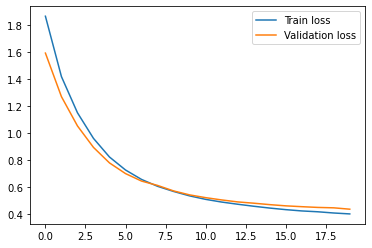

In [72]:
plot(loss_arr, loss_arr_test)

In [73]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.4345848023891449


Можно посмотреть, где именно сетка ошибается. 

In [74]:
_, y_pred = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors =  y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

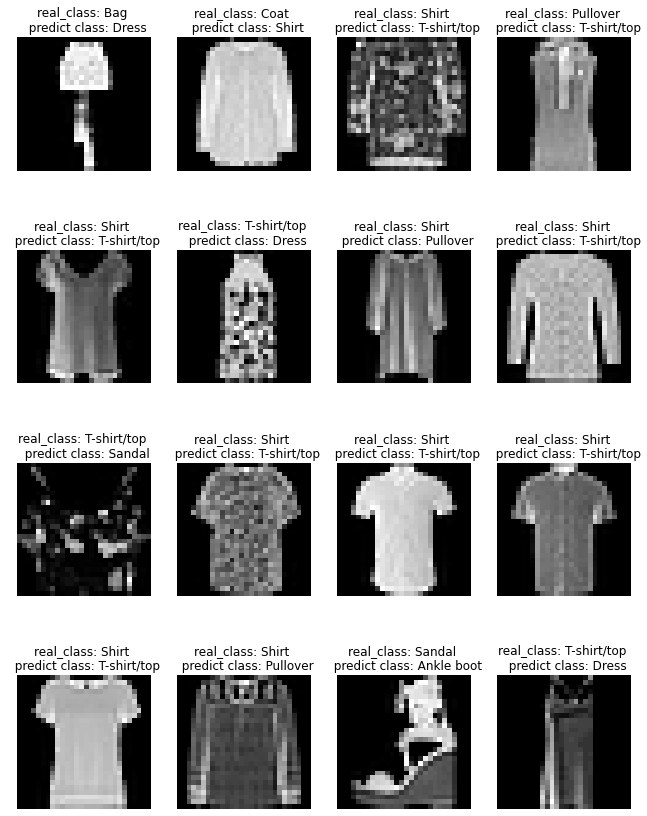

In [75]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

In [ ]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

In [ ]:
(28-5+0)+1

In [ ]:
nn.Conv3d()

In [ ]:
# 
#  Ваша LeNet сетка :) 
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                  out_channels=6,
                                                  kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=6,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.Tanh(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs
#         return logits

In [ ]:
inputs[0][0]

In [ ]:
nn.Flatten()(inputs[0])

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# model_cnn = CNN()
# model_cnn.to(device)
# loss_fn = nn.CrossEntropyLoss()
# opt = optim.SGD(model_cnn.parameters(), lr=0.01)

# loss_arr, loss_arr_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

In [ ]:
plot(loss_arr, loss_arr_test)

In [ ]:
print("Loss: ", loss_arr_test[-1])

In [ ]:
#отрисовка результатов
y_pred = model_2.predict_classes(X_test)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

Точность должна была довольно сильно подскочить, но пока этого не произошло. \

**Домашнее задание:** 
1. добавить в pipeline расчет точности в дополнение к loss (функция  training_loop)
2. улучшить качество обеих моделей (FC и CNN). В особенности CNN. Возможно, стоит изменить кол-во эпох, LR, optimizer...
3. Обернуть модель, функции обучения, валидации и рисования в класс. Тут нет четких критериев того, как это делать. Любые решения принимаются. Это важно для понимания того как работают классы. Можно начать с того, что поискать в интернете как обычно реализуются такие структуры.

#### Доп инфа на посмотреть:
Посмотрите на качество получившейся модели. Добавьте строки перевода пикселей картинки на отрезок -[0;255].
Переобучите сетку. Что произошло с качеством? (сравните еще эту ситуацию в модели с батчнормом и без)

Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?
